In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import glob
from PIL import Image
from collections import defaultdict
import math
from copy import deepcopy
import pandas as pd
import struct, os
import re, numpy as np
# from skimage import transform
import itertools, operator
import pickle
from torch.optim.lr_scheduler import _LRScheduler
from nltk.corpus import wordnet as wn

import sys
import xml.etree.ElementTree as ET

import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import Data1
import build
from build import Yolov2
import bbox

import nntool as nt 
import utils

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load dataset and settings

In [3]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'
batch_size = 32
CLASSES = ['sheep', 'horse', 'bicycle', 'bottle', 'cow', 'sofa', 'car', 'dog', 'cat', 'person', 'train', 'diningtable', 'aeroplane', 'bus', 'pottedplant', 'tvmonitor', 'chair', 'bird', 'boat', 'motorbike']
meta = defaultdict()
meta['anchors'] = 5
meta['classes'] = 20
meta['batch_size'] = batch_size
meta['threshold'] = 0.6
meta['anchor_bias'] = np.array([1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52])
meta['scale_no_obj'] = 1
meta['scale_coords'] = 1
meta['scale_class'] = 1
meta['scale_obj']  = 5
meta['iteration'] = 0 

In [4]:
train_set, test_set = Data1.getdata(dataset_root_dir)
meta['train_samples'] = len(train_set)
meta['iterations_per_epoch'] = meta['train_samples']/batch_size


In [7]:
x = train_set[0]
# x

## Set up stats manager

In [8]:
class YOLOStatsManager(nt.StatsManager):
    def __init__(self):
        super(YOLOStatsManager, self).__init__()

    def init(self):
        super(YOLOStatsManager, self).init()
        self.AP = 0
        self.n = 1e-6
        
    def accumulate(self, loss, x, y, d, mode): 
        super(YOLOStatsManager, self).accumulate(loss)
        if mode == 'test':
            AP, n = self.mAP(x, y, d)
            self.AP += AP
            self.n += n
        
    def summarize(self):
        loss = super(YOLOStatsManager, self).summarize() 
        return {'loss': loss, 'mAP': self.AP/self.n}

    def mAP(self, y, ground_truths, n_true, iou_thresh = 0.5):
        
        nms_output = bbox.get_nms_detections(y, 0.24, 0.3)
        n_truths = n_true.numpy()
        N = ground_truths.size(0)
    
        mean_avg_precision = Variable(torch.FloatTensor([0]))
        if torch.cuda.is_available():
            mean_avg_precision = mean_avg_precision.cuda()

        for batch in range(int(N)):
            category_map = defaultdict(lambda: defaultdict(lambda: torch.FloatTensor()))
        
            if n_truths[batch] == 0:
                continue

            ground_truth = ground_truths[batch, :n_truths[batch]]
            for gt in ground_truth:
                gt_class = gt[0].int().data[0]
                t1 = category_map[gt_class]['ground_truth']
                if len(t1.size()) == 0:
                    t1 = gt[1:].unsqueeze(0)
                else:
                    t1 = torch.cat([t1, gt[1:].unsqueeze(0)], 0)
                category_map[gt_class]['ground_truth'] = t1
            
            nms_boxes = nms_output[batch]
            if len(nms_boxes.size()) == 0:
                continue

            for box in nms_boxes:
                class_id = (torch.max(box[5:], 0)[1]).int().data[0]
                t2 = category_map[class_id]['prediction']
                if len(t2.size()) == 0:
                    t2 = box[:5].unsqueeze(0)
                else:
                    t2 = torch.cat([t2, box[:5].unsqueeze(0)], 0)
                category_map[class_id]['prediction'] = t2
            cat_ids = category_map.keys()
#         return category_map
            mean_avg_precision += torch.mean(torch.cat([calc_map(category_map[cat_id], iou_thresh) for cat_id in cat_ids], 0 ))
        return mean_avg_precision, N

## Exp1: train last 4 layers only

In [9]:
net = Yolov2()
net = build.load_pretrained_weights(net)
build.model_freeze_upto(net, 36)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

<generator object Module.children at 0x7f9c688c3308>
conv19.weight torch.Size([1024, 1024, 3, 3]) True
batchnorm19.weight torch.Size([1024]) True
batchnorm19.bias torch.Size([1024]) True
conv20.weight torch.Size([1024, 1024, 3, 3]) True
batchnorm20.weight torch.Size([1024]) True
batchnorm20.bias torch.Size([1024]) True
conv21.weight torch.Size([1024, 3072, 3, 3]) True
batchnorm21.weight torch.Size([1024]) True
batchnorm21.bias torch.Size([1024]) True
conv22.weight torch.Size([125, 1024, 1, 1]) True
conv22.bias torch.Size([125]) True


In [11]:
# !rm -r yolo_voc1

lr = 0.00025
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, meta, output_dir="yolo_voc1", 
                     batch_size = batch_size, perform_validation_during_training=False)

RuntimeError: Error(s) in loading state_dict for Yolov2:
	Missing key(s) in state_dict: "batchnorm1.weight", "batchnorm1.bias", "batchnorm1.running_mean", "batchnorm1.running_var", "batchnorm2.weight", "batchnorm2.bias", "batchnorm2.running_mean", "batchnorm2.running_var", "batchnorm3.weight", "batchnorm3.bias", "batchnorm3.running_mean", "batchnorm3.running_var", "batchnorm4.weight", "batchnorm4.bias", "batchnorm4.running_mean", "batchnorm4.running_var", "batchnorm5.weight", "batchnorm5.bias", "batchnorm5.running_mean", "batchnorm5.running_var", "batchnorm6.weight", "batchnorm6.bias", "batchnorm6.running_mean", "batchnorm6.running_var", "batchnorm7.weight", "batchnorm7.bias", "batchnorm7.running_mean", "batchnorm7.running_var", "batchnorm8.weight", "batchnorm8.bias", "batchnorm8.running_mean", "batchnorm8.running_var", "batchnorm9.weight", "batchnorm9.bias", "batchnorm9.running_mean", "batchnorm9.running_var", "batchnorm10.weight", "batchnorm10.bias", "batchnorm10.running_mean", "batchnorm10.running_var", "batchnorm11.weight", "batchnorm11.bias", "batchnorm11.running_mean", "batchnorm11.running_var", "batchnorm12.weight", "batchnorm12.bias", "batchnorm12.running_mean", "batchnorm12.running_var", "batchnorm13.weight", "batchnorm13.bias", "batchnorm13.running_mean", "batchnorm13.running_var", "batchnorm14.weight", "batchnorm14.bias", "batchnorm14.running_mean", "batchnorm14.running_var", "batchnorm15.weight", "batchnorm15.bias", "batchnorm15.running_mean", "batchnorm15.running_var", "batchnorm16.weight", "batchnorm16.bias", "batchnorm16.running_mean", "batchnorm16.running_var", "batchnorm17.weight", "batchnorm17.bias", "batchnorm17.running_mean", "batchnorm17.running_var", "batchnorm18.weight", "batchnorm18.bias", "batchnorm18.running_mean", "batchnorm18.running_var", "batchnorm19.weight", "batchnorm19.bias", "batchnorm19.running_mean", "batchnorm19.running_var", "batchnorm20.weight", "batchnorm20.bias", "batchnorm20.running_mean", "batchnorm20.running_var", "batchnorm21.weight", "batchnorm21.bias", "batchnorm21.running_mean", "batchnorm21.running_var". 
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn3.num_batches_tracked", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var", "bn4.num_batches_tracked", "bn5.weight", "bn5.bias", "bn5.running_mean", "bn5.running_var", "bn5.num_batches_tracked", "bn6.weight", "bn6.bias", "bn6.running_mean", "bn6.running_var", "bn6.num_batches_tracked", "bn7.weight", "bn7.bias", "bn7.running_mean", "bn7.running_var", "bn7.num_batches_tracked", "bn8.weight", "bn8.bias", "bn8.running_mean", "bn8.running_var", "bn8.num_batches_tracked", "bn9.weight", "bn9.bias", "bn9.running_mean", "bn9.running_var", "bn9.num_batches_tracked", "bn10.weight", "bn10.bias", "bn10.running_mean", "bn10.running_var", "bn10.num_batches_tracked", "bn11.weight", "bn11.bias", "bn11.running_mean", "bn11.running_var", "bn11.num_batches_tracked", "bn12.weight", "bn12.bias", "bn12.running_mean", "bn12.running_var", "bn12.num_batches_tracked", "bn13.weight", "bn13.bias", "bn13.running_mean", "bn13.running_var", "bn13.num_batches_tracked", "bn14.weight", "bn14.bias", "bn14.running_mean", "bn14.running_var", "bn14.num_batches_tracked", "bn15.weight", "bn15.bias", "bn15.running_mean", "bn15.running_var", "bn15.num_batches_tracked", "bn16.weight", "bn16.bias", "bn16.running_mean", "bn16.running_var", "bn16.num_batches_tracked", "bn17.weight", "bn17.bias", "bn17.running_mean", "bn17.running_var", "bn17.num_batches_tracked", "bn18.weight", "bn18.bias", "bn18.running_mean", "bn18.running_var", "bn18.num_batches_tracked", "bn19.weight", "bn19.bias", "bn19.running_mean", "bn19.running_var", "bn19.num_batches_tracked", "bn20.weight", "bn20.bias", "bn20.running_mean", "bn20.running_var", "bn20.num_batches_tracked", "bn21.weight", "bn21.bias", "bn21.running_mean", "bn21.running_var", "bn21.num_batches_tracked". 

In [ ]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(len(exp.history))], label="training loss")
#     axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    plt.xticks([18,36,54,72], ['epoch 1', 'epoch 2', 'epoch 3', 'epoch 4'], rotation=45)    
    plt.tight_layout()
    fig.canvas.draw()
#     axes.set_ylim([0,50])
    axes.legend()

# torch.backends.cudnn.enabled=False
# fig, axes = plt.subplots(ncols=1, figsize=(12, 5))
# exp1.run(num_epochs=4, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [1]:
# torch.backends.cudnn.enabled=False
# exp1.evaluate()

In [12]:
#evaluate
conf_threshold = 0.35     #default 0.35
nms_threshold = 0.5     #default 0.5
idx = 0
x = torch.from_numpy(train_set[idx][0]).view(1,3,448,448).float()
y = exp1.net.forward(x.to(device))
predictions = utils.post_processing(y, 448, CLASSES, net.anchors, conf_threshold,
                    nms_threshold)
 

img_name = train_set.imgnames[idx]
utils.draw_boxes(img_name, predictions)


NameError: name 'exp1' is not defined

## Exp2: Fine-tuning: train all layers

In [10]:
net = Yolov2()
net = build.load_pretrained_weights(net)
build.model_freeze_upto(net, 0)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

<generator object Module.children at 0x7f5f498c4e08>
conv1.weight torch.Size([32, 3, 3, 3]) True
bn1.weight torch.Size([32]) True
bn1.bias torch.Size([32]) True
conv2.weight torch.Size([64, 32, 3, 3]) True
bn2.weight torch.Size([64]) True
bn2.bias torch.Size([64]) True
conv3.weight torch.Size([128, 64, 3, 3]) True
bn3.weight torch.Size([128]) True
bn3.bias torch.Size([128]) True
conv4.weight torch.Size([64, 128, 1, 1]) True
bn4.weight torch.Size([64]) True
bn4.bias torch.Size([64]) True
conv5.weight torch.Size([128, 64, 3, 3]) True
bn5.weight torch.Size([128]) True
bn5.bias torch.Size([128]) True
conv6.weight torch.Size([256, 128, 3, 3]) True
bn6.weight torch.Size([256]) True
bn6.bias torch.Size([256]) True
conv7.weight torch.Size([128, 256, 1, 1]) True
bn7.weight torch.Size([128]) True
bn7.bias torch.Size([128]) True
conv8.weight torch.Size([256, 128, 3, 3]) True
bn8.weight torch.Size([256]) True
bn8.bias torch.Size([256]) True
conv9.weight torch.Size([512, 256, 3, 3]) True
bn9.weight

In [12]:
#!rm -r yolo_voc2

lr = 0.00025
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = YOLOStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, meta, output_dir="yolo_voc2", 
                     batch_size = batch_size, perform_validation_during_training=False)

Start/Continue training from epoch 8
Finish training for 4 epochs


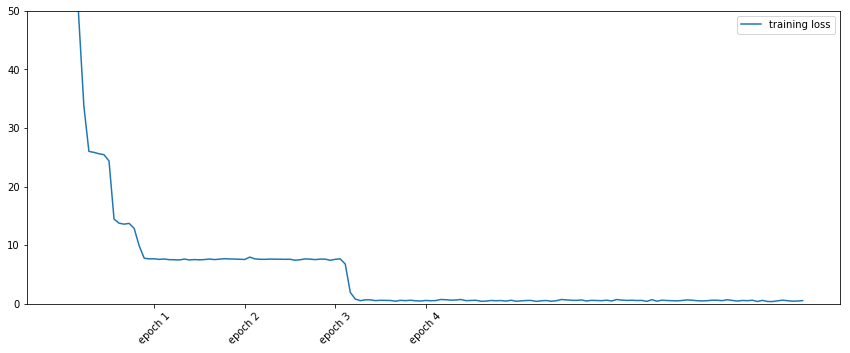

In [13]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k]['loss'] for k in range(len(exp.history))], label="training loss")
#     axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    plt.xticks([18,36,54,72], ['epoch 1', 'epoch 2', 'epoch 3', 'epoch 4'], rotation=45)    
    plt.tight_layout()
    fig.canvas.draw()
    axes.set_ylim([0,50])
    axes.legend()

fig, axes = plt.subplots(ncols=1, figsize=(12, 5))
exp2.run(num_epochs=4, plot=lambda exp: plot(exp, fig=fig, axes=axes))

[[0.         0.         0.         0.        ]
 [0.03620392 0.03008816 0.75542206 0.51634991]]


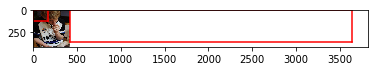

In [37]:
#evaluate
# test_loader = td.DataLoader(test_set,
#                                      batch_size=batch_size,
#                                      shuffle=True,
#                                      drop_last=True,
#                                      pin_memory=True)
# for i, test_data in enumerate(test_loader):
#     test_images = Variable(test_data["image"], requires_grad=True).cuda().float()
#     test_labels = Variable(test_data["bboxes"], requires_grad=False).cuda().float()
#     test_n_true = test_data["n_true"]
#     break

test = test_set[2]['image'].float().to(device).view(1,3,416,416)

net = net.cuda()
a=net.forward(test)
nnms = bbox.get_nms_detections(a, 0, 0.1)
# nnms
bbox.draw_bbox_torch({"image": test_images[0].cpu().data, "bboxes": test_labels[0].cpu().data})
bbox.draw_bbox_nms(test_images[0].cpu(), nnms[0].cpu())


## Exp3: Cosine annealing learning rate

In [ ]:
class CosineAnnealing(_LRScheduler):

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealing, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]

In [ ]:
net = Yolov2()
net = build.load_pretrained_weights(net)
build.model_freeze_upto(net, 36)
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

In [ ]:
#!rm -r yolo_voc3

lr = 0.00025
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
ca = CosineAnnealing(adam, 300)
stats_manager = YOLOStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, ca, stats_manager, meta, output_dir="yolo_voc3", 
                     batch_size = batch_size, perform_validation_during_training=False)